In [29]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import pprint
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.utils import save_model
import onnxruntime as rt
import onnx
import pyomo.environ as pe
from omlt.block import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel

In [19]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [20]:
X = df["theta"]
y = df["z"]

X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)

X.shape, y.shape

((180, 1), (180, 1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
reg.predict(X_test)
reg.score(X_test, y_test)

c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.999373819339718

In [22]:
y_pred = reg.predict(X)

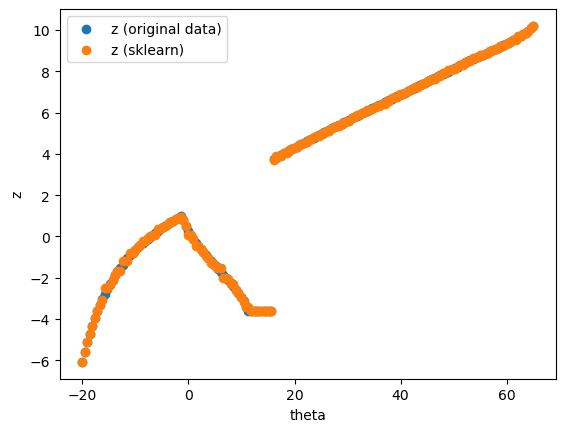

In [23]:
# plotting results
plt.scatter(X, y, label='z (original data)')
plt.scatter(X, y_pred, label='z (sklearn)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

In [24]:
initial_type = [('float_input', FloatTensorType([-1, 1]))]
onx = convert_sklearn(reg, initial_types=initial_type)
with open("./output/sklearn_boosting.onnx", "wb") as f:
    f.write(onx.SerializeToString())

input name float_input
input shape [None, 1]
input type tensor(float)
output name variable
output shape [None, 1]
output type tensor(float)


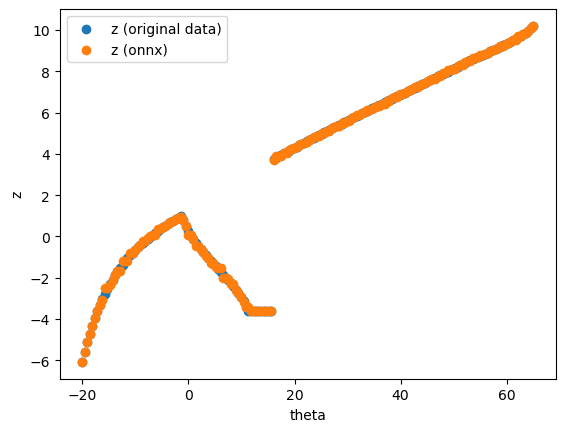

In [25]:
sess = rt.InferenceSession("./output/sklearn_boosting.onnx")
input_name = sess.get_inputs()[0].name
print("input name", input_name)
input_shape = sess.get_inputs()[0].shape
print("input shape", input_shape)
input_type = sess.get_inputs()[0].type
print("input type", input_type)
output_name = sess.get_outputs()[0].name
print("output name", output_name)
output_shape = sess.get_outputs()[0].shape
print("output shape", output_shape)
output_type = sess.get_outputs()[0].type
print("output type", output_type)
pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, pred_onx, label = 'z (onnx)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

In [31]:
model_onnx = onnx.load('./output/sklearn_boosting.onnx')
# model_onnx

In [34]:
onnx_model = onx

In [41]:
f_bnds = [(float(min(X)), float(max(X))) for _ in range(1)]
f_bnds

[(-20.0, 65.0)]

In [43]:
opt_model = pe.ConcreteModel()
opt_model.gbt = OmltBlock()
gbt_model = GradientBoostedTreeModel(onnx_model, 
                                     scaled_input_bounds=f_bnds)

# omlt uses a big-m formulation to encode the tree models
formulation = GBTBigMFormulation(gbt_model)
opt_model.gbt.build_formulation(formulation)